In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
data_dir = '/content/drive/My Drive/COVIDector Dataset/data' #Path to your dataset directory

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15682 files belonging to 2 classes.
Using 12546 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15682 files belonging to 2 classes.
Using 3136 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['negative', 'positive']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomZoom(0.15),
    layers.experimental.preprocessing.RandomContrast(0.15)
  ]
)

In [ ]:
num_classes = 2
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#model.summary()
lr = 0.001 #Default Learning Rate 
adam = Adam(lr)

# Define the Required Callback Function
class printlearningrate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr)
        Epoch_count = epoch + 1
        print('\n', "Epoch:", Epoch_count, ', LR:', lr)

printlr = printlearningrate() 

def lr_schedule(epoch):
    learning_rate = 0.001
    if epoch > 10:
        learning_rate = 0.00075
    if epoch > 20:
        learning_rate = 0.0005
    if epoch > 40:
        learning_rate = 0.0001
    return learning_rate

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

model.compile(optimizer=adam, 
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

epochs = 50
history = model.fit(
          train_ds,
          epochs=epochs,
          validation_data=val_ds,
          verbose=1,
         # callbacks=[printlr, lr_callback] # If you want to decay or change the learning rate and record its history.
)

Epoch 1/50
393/393 [==============================] - 6327s 3s/step - loss: 0.4802 - accuracy: 0.8731 - val_loss: 0.2211 - val_accuracy: 0.9126
Epoch 2/50
393/393 [==============================] - 12s 31ms/step - loss: 0.2306 - accuracy: 0.9123 - val_loss: 0.1855 - val_accuracy: 0.9276
Epoch 3/50
393/393 [==============================] - 12s 30ms/step - loss: 0.2035 - accuracy: 0.9245 - val_loss: 0.1848 - val_accuracy: 0.9353
Epoch 4/50
393/393 [==============================] - 12s 30ms/step - loss: 0.1788 - accuracy: 0.9300 - val_loss: 0.1755 - val_accuracy: 0.9388
Epoch 5/50
393/393 [==============================] - 12s 30ms/step - loss: 0.1672 - accuracy: 0.9357 - val_loss: 0.1452 - val_accuracy: 0.9480
Epoch 6/50
393/393 [==============================] - 12s 30ms/step - loss: 0.1440 - accuracy: 0.9469 - val_loss: 0.1451 - val_accuracy: 0.9436
Epoch 7/50
393/393 [==============================] - 12s 30ms/step - loss: 0.1294 - accuracy: 0.9529 - val_loss: 0.1346 - val_accuracy:

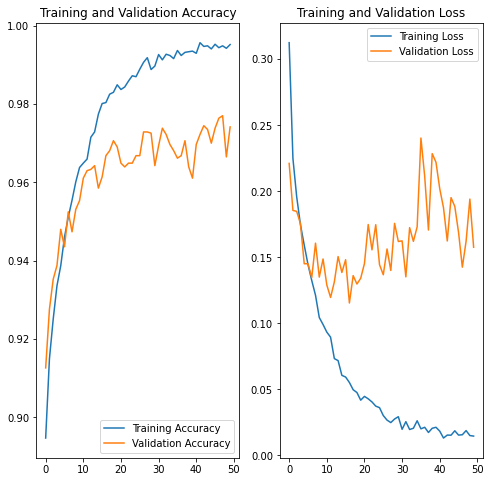

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
#learning_rate = history.history['lr']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

In [ ]:
path = '/content/drive/MyDrive/COVIDNetV2'
model.save(path) # Convert into SavedModel format

INFO:tensorflow:Assets written to: /content/drive/MyDrive/COVIDNetV2/assets


<h1>All the modifications performed:</h1>

<li>Constant default (0.001) Default Learning Rate with Adam optimizer, for 10 epochs. Accuracy - 0.916</li>
<li>Constant default (0.001) Default Learning Rate with Adam optimizer, for 15 epochs, with data augmentation of Horizontal RandomFlip and RandomZoom(0.1). Accuracy - 0.93</li>
<li>Constant default (0.001) Default Learning Rate with Adam optimizer, for 10 epochs, with data augmentation of Horizontal RandomFlip, RandomZoom(0.15), RandomContrast(0.15). Accuracy - ~0.9</li>
<li>Constant default (0.001) Default Learning Rate with Adam optimizer, for 20 epochs, with data augmentation of Horizontal RandomFlip, RandomZoom(0.15), RandomContrast(0.15). Accuracy - ~0.9</li>
<li>Initial Learning Rate is Default (0.001) Learning Rate with Adam optimizer which increases by 0.01 with every epoch, for 50 epochs, with data augmentation of RandomZoom(0.15), RandomContrast(0.15). Accuracy - 0.8905 (was constant throughout from first epoch to the last one)</li>
<li>Constant default (0.001) Default Learning Rate with Adam optimizer, for 50 epochs, with data augmentation of RandomZoom(0.15), RandomContrast(0.15). Accuracy - 0.9406</li>
<h3> The following modifications were run with a Batch Size - 32</h3>
<li>Constant default (0.001) Default Learning Rate with Adam optimizer, for 50 epochs, with data augmentation of RandomZoom(0.15), RandomContrast(0.15). Batch Size - 32, Accuracy - 0.9703.</li>
<li>Decreasing Learning Rate. Initial: 0.001, After Epoch 11: 0.00075, After Epoch 20: 0.0005, After Epoch 40: 0.0001 with Adam optimizer for 50 epochs (Step=393). Data augmentation of RandomZoom(0.15), RandomContrast(0.15). Batch Size: 32 (To accomodate in Colab). Accuracy - 0.9739</li>
<li>Constant (0.01) Default Learning Rate with SGD optimizer, for 50 epochs, with data augmentation of RandomZoom(0.15), RandomContrast(0.15). Accuracy - 0.9624</li>
<li>Constant (0.001) Learning Rate with SGD optimizer, for 50 epochs, with data augmentation of RandomZoom(0.15), RandomContrast(0.15). Accuracy - 0.9308</li>
<li>Decreasing Learning Rate with SGD optimizer. Initial: 0.001, After Epoch 11: 0.00075, After Epoch 20: 0.0005, After Epoch 40: 0.0001 with Adam optimizer for 50 epochs (Step=393). Data augmentation of RandomZoom(0.15), RandomContrast(0.15). Batch Size: 32 (To accomodate in Colab). Accuracy - 0.926</li>
<li>Constant (0.001) Learning Rate with Adagrad optimizer, for 50 epochs, with data augmentation of RandomZoom(0.15), RandomContrast(0.15). Accuracy - 0.9375</li>
<li>Constant (0.001) Learning Rate with RMSprop optimizer, for 50 epochs, with data augmentation of RandomZoom(0.15), RandomContrast(0.15). Accuracy - 0.9483. The validation loss graph is very haphazard and not following a path.</li>
<h2>Final Model Specification:</h2>
<li>Constant (0.001) Default Learning Rate, Adam optimizer, 50 epochs, data augmentation of RandomZoom(0.15), RandomContrast(0.15), Batch Size - 32, Accuracy - 0.9742</li>